In [1]:
import os
import subprocess
import sys
import ribasim
import ribasim.nodes
import toml
import tomli
import numpy as np
import pandas as pd
import pathlib
import tqdm.auto as tqdm
import warnings
import datetime
from pathlib import Path
import logging

from shapely.geometry import Point

#load ribasim_nl
module_path = Path.cwd() / '../../ribasim_nl/'
sys.path.append(str(module_path))
from ribasim_nl import CloudStorage

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

%reload_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')
    
import peilbeheerst_model.ribasim_parametrization as ribasim_param

from peilbeheerst_model.ribasim_feedback_processor import RibasimFeedbackProcessor
from peilbeheerst_model.add_storage_basins import AddStorageBasin
from peilbeheerst_model.controle_output import *
from ribasim import Solver

from ribasim import Allocation, Model, Node
from ribasim.nodes import (
    basin,
    discrete_control,
    flow_boundary,
    fractional_flow,
    level_boundary,
    level_demand,
    linear_resistance,
    manning_resistance,
    outlet,
    pid_control,
    pump,
    tabulated_rating_curve,
    user_demand,
)

## Define variables and model

#### Set Config

In [2]:
# Set paths
waterschap = "Scheldestromen"
versie = "2024_6_1"

work_dir = pathlib.Path(r"../../../../../Ribasim_updated_models", waterschap)
ribasim_gpkg = work_dir.joinpath("database.gpkg")
path_ribasim_toml = work_dir.joinpath("ribasim.toml")
output_dir = work_dir.joinpath("results")

# Basin area percentage
regular_percentage = 10
boezem_percentage = 90
unknown_streefpeil = 0.00012345 #we need a streefpeil to create the profiles, Q(h)-relations, and af- and aanslag peil for pumps

# Forcing settings
start_time = "2024-01-01"
timestep_size = 'd'
timesteps = 2

default_boundary_level = 0

## Process the feedback form

In [3]:
name = "Ron Bruijns (HKV)"

feedback_excel = pathlib.Path(r"../../../../../Ribasim_feedback/V1_formulieren/feedback_formulier_" + waterschap + ".xlsx")
feedback_excel_processed = r"../../../../..//Ribasim_feedback/V1_formulieren_verwerkt/feedback_formulier_" + waterschap + "_JA_processed.xlsx"

ribasim_toml = pathlib.Path(r"../../../../../Ribasim_base_models", waterschap + '_boezemmodel_' + versie, 'ribasim.toml')

# r"../../../../../Ribasim_base_models/AmstelGooienVecht_boezemmodel_2024_6_8/ribasim.toml"
output_folder = work_dir #r"../../../../../Ribasim_updated_models/AmstelGooienVecht"

processor = RibasimFeedbackProcessor(name, waterschap, versie, feedback_excel, ribasim_toml, output_folder, feedback_excel_processed)
processor.run()

186 92
190 29
33 29
Processed all actions


#### Load model

In [4]:
# Load Ribasim model
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    ribasim_model = ribasim.Model(filepath=path_ribasim_toml)

## Model specific tweaks

In [5]:
assert not pd.isnull(ribasim_model.basin.area.df.meta_streefpeil).any()

ribasim_model.basin.area.df.loc[ribasim_model.basin.area.df['meta_streefpeil'] == 'Onbekend streefpeil', 'meta_streefpeil'] = unknown_streefpeil

ribasim_model.basin.area.df.loc[ribasim_model.basin.area.df['meta_streefpeil'] == 9.999, 'meta_streefpeil'] = unknown_streefpeil

# Parameterization

## Nodes

### Basin (characteristics)

In [6]:
# Define the initial state of each basin. Is set equal to the streefpeil
# ribasim_param.set_initial_basin_state(ribasim_model) #the initial states of the basins are by default already set to the streefpeil!
# ribasim_model.basin.area


In [7]:
# Add storage basins
model_name = 'Scheldestromen_StorageBasins'
# node_ids = [1, 2, 3]  # Specify node IDs to process or include_hoofdwater Boolean
processor = AddStorageBasin(ribasim_toml, model_name, output_folder, include_hoofdwater=True, log=True, node_ids=None)
ribasim_model = processor.run()

# Insert standard profiles to each basin. These are [depth_profiles] meter deep, defined from the streefpeil
ribasim_param.insert_standard_profile(ribasim_model, 
                                      regular_percentage = regular_percentage, 
                                      boezem_percentage = boezem_percentage,
                                      depth_profile = 2)

# Check basin area
ribasim_param.validate_basin_area(ribasim_model)

All basins are larger than 100 m²


### Basin (forcing)

In [8]:
# Set static forcing
forcing_dict = {'precipitation':         ribasim_param.convert_mm_day_to_m_sec(0),
                'potential_evaporation': ribasim_param.convert_mm_day_to_m_sec(0),
                'drainage':              ribasim_param.convert_mm_day_to_m_sec(0),
                'infiltration':          ribasim_param.convert_mm_day_to_m_sec(0),
                'urban_runoff':          ribasim_param.convert_mm_day_to_m_sec(0),
                }

ribasim_param.set_static_forcing(timesteps, timestep_size, start_time, forcing_dict, ribasim_model)


### Pumps

In [9]:
# Set pump capacity for each pump
ribasim_model.pump.static.df['flow_rate'] = 0.16667 # 10 kuub per minuut

### Convert all boundary nodes to LevelBoundaries

In [10]:
ribasim_param.Terminals_to_LevelBoundaries(ribasim_model = ribasim_model,
                                           default_level = default_boundary_level)

ribasim_param.FlowBoundaries_to_LevelBoundaries(ribasim_model = ribasim_model,
                                                default_level = default_boundary_level)


### FlowBoundary

In [11]:
# Set FlowBoundary rate for each pump
# ribasim_model.flow_boundary.static.df['flow_rate'] = 0 #

### Add Discrete Control

In [12]:
# Add discrete control nodes and control edges
ribasim_param.add_discrete_control_nodes(ribasim_model)

Model bevat al discrete controls! Dan voegen we geen extra controls toe...


### TabulatedRatingCurve

In [13]:
# First, set the Q(h)-relationship to a relationship which is at each TRC node the same
ribasim_param.set_tabulated_rating_curves(ribasim_model, level_increase=1.0, flow_rate=1)

# The water level in the boezem is regulated heavily. There is a smaller tolerance for an increase in water level. 
# Hence, the TRC's which discharge water from the boezem to a Terminal should have a higher capacity.
ribasim_param.set_tabulated_rating_curves_boundaries(ribasim_model, level_increase=0.10, flow_rate=40)


# Set numerical settings

In [14]:
# Write model output
ribasim_param.index_reset(ribasim_model)
ribasim_model.starttime = datetime.datetime(2024, 1, 1)
ribasim_model.endtime = datetime.datetime(2024, 1, 5)
ribasim_model.solver.saveat = 3600
ribasim_param.write_ribasim_model_Zdrive(ribasim_model, 
                                         path_ribasim_toml)

## Run Model

## Iterate over tabulated rating curves

In [15]:
# !ribasim '../../../../../Ribasim_updated_models/Scheldestromen/ribasim.toml'

<Axes: >

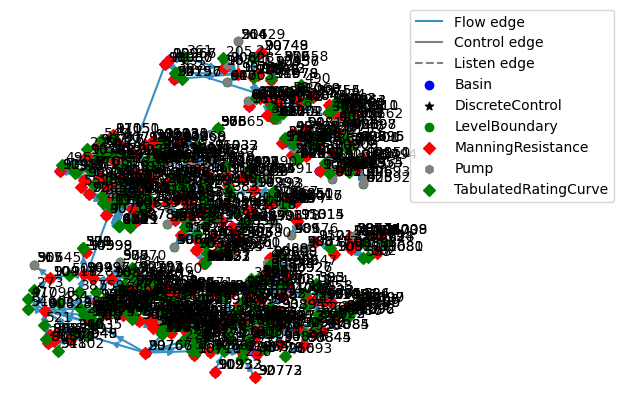

In [21]:
ribasim_model.plot()

In [16]:
try:
    ribasim_param.iterate_TRC(ribasim_param = ribasim_param, 
                              allowed_tolerance = 0.02, 
                              max_iter = 1, 
                              expected_difference = 0.1, 
                              max_adjustment = 0.25, 
                              cmd = ['ribasim', path_ribasim_toml], 
                              output_dir = output_dir, 
                              path_ribasim_toml = path_ribasim_toml)

except Exception as e:
    logging.error("The model was not able to run. Log file:")
    log_file_path = os.path.join(output_dir, 'ribasim.log') 
    try:
        with open(log_file_path, 'r') as log_file:
            log_content = log_file.read()
            print(log_content)
    except Exception as log_exception:
        logging.error(f"Could not read the log file: {log_exception}")

Simulating init:   0%|          | 0/100 [00:00<?, ?it/s]

┌ Info: Starting a Ribasim simulation.
│   cli.ribasim_version = 2024.8.0
│   starttime = 2024-01-01T00:00:00
│   endtime = 2024-01-05T00:00:00
└ @ Ribasim /opt/teamcityagent/work/ecd2b8f9b25b1609/ribasim/core/src/main.jl:39
┌ Error: TabulatedRatingCurve node IDs don't match.
└ @ Ribasim /opt/teamcityagent/work/ecd2b8f9b25b1609/ribasim/core/src/read.jl:193



# Write model

In [30]:
# control_dict = Control(work_dir = work_dir).run_all()
ribasim_param.write_ribasim_model_GoodCloud(ribasim_model = ribasim_model, 
                                            path_ribasim_toml = path_ribasim_toml,
                                            waterschap = waterschap, 
                                            modeltype = 'boezemmodel',
                                            include_results = True)


The model of waterboard Scheldestromen has been uploaded to the goodcloud in the directory of boezemmodel!


## Open Output

In [ ]:
df_basin = pd.read_feather(os.path.join(output_dir, 'basin.arrow'))
df_basin